In [ ]:
from google.colab import files
files.upload() #select the .npz file to get dataset 

Saving notMNIST.npz to notMNIST.npz


In [ ]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load():
  with np.load("notMNIST.npz") as data:
    Data, Target = data ["images"], data["labels"]
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data = Data[randIndx]/255.
    Target = Target[randIndx]
    trainData, trainTarget = Data[:15000], Target[:15000]
    validData, validTarget = Data[15000:16000], Target[15000:16000]
    testData, testTarget = Data[16000:], Target[16000:]
  return trainData, validData, testData, trainTarget, validTarget, testTarget

In [ ]:
def convertOneHot(trainTarget, validTarget, testTarget):
  newtrain = np.zeros((trainTarget.shape[0], 10))
  newvalid = np.zeros((validTarget.shape[0], 10))
  newtest = np.zeros((testTarget.shape[0], 10))
  for item in range(0, trainTarget.shape[0]):
    newtrain[item][trainTarget[item]] = 1
  for item in range(0, validTarget.shape[0]):
    newvalid[item][validTarget[item]] = 1
  for item in range(0, testTarget.shape[0]):
    newtest[item][testTarget[item]] = 1
  return newtrain, newvalid, newtest

In [ ]:
################### 1.1 Helper Functions ###################

def relu(x):
    relu_ = np.maximum(x, 0)
    return relu_


def softmax(x):
    b = np.max(x)
    softmax_ = np.exp (x - b) / np.sum (np.exp(x - b) , axis=1, keepdims = True)
    return softmax_


def compute(X, W, b) :
    return np.matmul(X, W) + b


def averageCE(yn, y_hat):
    return -1 * np.mean(yn * np.log(y_hat))


def gradCE (yn, y_hat):
    return y_hat - yn
def cross_ent(target, prediction):
    x = -np.mean(target*np.log(prediction))
    return x 

In [ ]:
################### 1.2 Back Propagation ###################

def grad_wo(yn, y_hat, h):
    dL_dz = gradCE(yn, y_hat) # chain rule
    dz_dwo = np.transpose(h)
    return np.matmul(dz_dwo, dL_dz)

def grad_bo(yn, y_hat):
    dL_dz = gradCE(yn, y_hat)
    dz_dbo = np.ones((1 , yn.shape[0])) #len(target) should also work
    return np. matmul(dz_dbo, dL_dz)

def grad_wh(yn, y_hat, x, s_o,weight):
    dL_dz = gradCE (yn , y_hat)
    s_o = 1 * (s_o > 0)
    #print(np.shape(dL_dz),np.shape(weight))
    tmp =  s_o*np.matmul(dL_dz,np.transpose(weight)) 
    return np.matmul(np.transpose(x), tmp)

def grad_bh(yn, y_hat, s_o,weight):
    dL_dz = gradCE(yn, y_hat)
    s_o = 1 * (s_o > 0)
    dz_db = np.ones((1, yn.shape[0]))
    tmp = np.matmul(dL_dz, np.transpose(weight)) * s_o
    return np . matmul (dz_db , tmp)



In [ ]:
def help (x,y,W2,b2,W1,b1):
    import operator
    h_in = relu(np.add(np.matmul(x, W2), b2))
    h_out = relu(h_in)
    y_hat = softmax(np.add(np.matmul(h_out, W1), b1))
    loss= (cross_ent(y, y_hat))
    count = 0
    for i in range(len(y)):
      index, value = max(enumerate(y[i]), key=operator.itemgetter(1))
      index1, value1 = max(enumerate(y_hat[i]), key=operator.itemgetter(1))
      if index1==index: count+=1
    accuracy = count/ len(y)



    return loss, accuracy, y_hat, h_out,h_in

In [ ]:
def learning(X1, X2, X3, y1, y2,  y3, hidden_units , epochs , gamma , learning_rate ):
  
    acc1, acc2, acc3, L1, L2, L3  = [] ,[], [], [], [], []

    W1 = np.random.normal(0, np.sqrt(2/(hidden_units+10)), (hidden_units,10))
    W2 = np.random.normal(0, np.sqrt(2/(X1.shape[0]+hidden_units)), (X1.shape[1],hidden_units))

    b1 = np.zeros((1, 10))
    b2 = np.zeros((1, hidden_units))

    v1 = np.full((hidden_units, 10), 1e-5)
    v2 = np.full((X1.shape[1],hidden_units), 1e-5)

    b1_temp = b1
    b2_temp = b2

    for i in range(epochs):
        if i%10==0: print("Iteration:", i)
        loss1, accuracy1, y_hat, h_out, h_in = help(X1,y1,W2,b2,W1,b1)
        loss2, accuracy2, y_hat2, _, _ = help(X2,y2,W2,b2,W1,b1)
        loss3, accuracy3, y_hat3, _, _ = help(X3,y3,W2,b2,W1,b1)

        acc1.append(accuracy1)
        acc2.append(accuracy2)
        acc3.append(accuracy3)
        L1.append(loss1)
        L2.append(loss2)
        L3.append(loss3)
    

        b1_temp = gamma*b1_temp + learning_rate*grad_bo(y1, y_hat)
        b2_temp = gamma*b2_temp + learning_rate*grad_bh(y1, y_hat, h_in, W1)

        v1 = gamma*v1 + learning_rate*grad_wo(y1, y_hat, h_out)
        v2 = gamma*v2 + learning_rate*grad_wh(y1, y_hat, X1, h_in, W1)
        
        W1 = W1 - v1
        W2 = W2 - v2
        b1 = b1 - b1_temp
        b2 = b2 - b2_temp
        #print(np.sum( W1))

    return acc1, acc2, acc3, L1, L2, L3

In [ ]:
X1, X2, X3, y1, y2, y3 = load()
X1, X2, X3 = X1.reshape((X1.shape[0], -1)),X2.reshape((X2.shape[0], -1)),X3.reshape((X3.shape[0], -1))

y1, y2, y3 = convertOneHot(y1, y2, y3)

In [ ]:
acc11, acc21, acc31, L11, L21, L31 = learning(X1,X2,X3,y1,y2,y3, 
  hidden_units = 2000, 
  epochs = 200, 
  gamma = 0.90, 
  learning_rate = 1e-5 )



In [ ]:
acc12, acc22, acc32, L12, L22, L32 = learning(X1,X2,X3,y1,y2,y3, 
  hidden_units = 1000, 
  epochs = 200, 
  gamma = 0.90, 
  learning_rate = 1e-5 )

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190


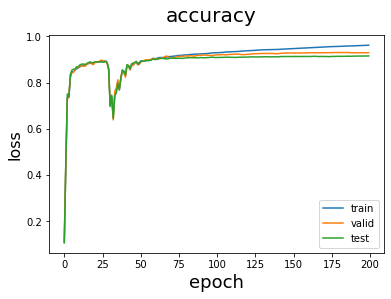

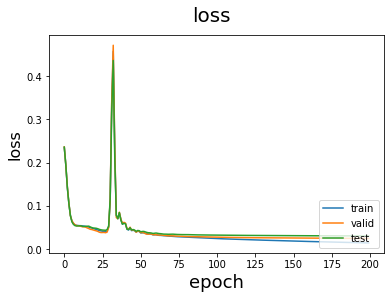

In [ ]:
fig = plt.figure()
plt.plot(acc12)
plt.plot(acc22)
plt.plot(acc32)
plt.legend(['train','valid','test'], loc='lower right')
fig.suptitle('accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.show()

fig = plt.figure()
plt.plot(L12)
plt.plot(L22)
plt.plot(L32)
plt.legend(['train','valid','test'], loc='lower right')
fig.suptitle('loss', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.show()



In [ ]:

acc13, acc23, acc33, L13, L23, L33 = learning(X1,X2,X3,y1,y2,y3, 
  hidden_units = 500, 
  epochs = 200, 
  gamma = 0.90, 
  learning_rate = 1e-5 )
acc14, acc24, acc34, L14, L24, L34 = learning(X1,X2,X3,y1,y2,y3, 
  hidden_units = 100, 
  epochs = 200, 
  gamma = 0.90, 
  learning_rate = 1e-5 )

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190


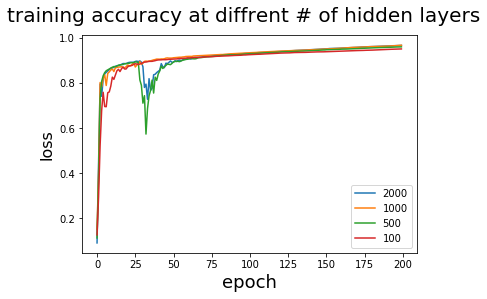

accuracies [2000,1000,500,100] 0.9657333333333333 0.9664666666666667 0.9593333333333334 0.9501333333333334


In [ ]:
fig = plt.figure()
plt.plot(acc11)
plt.plot(acc12)
plt.plot(acc13)
plt.plot(acc14)
fig.suptitle('training accuracy at diffrent # of hidden layers', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(['2000','1000','500','100'], loc='lower right')
plt.show()
print("accuracies [2000,1000,500,100]", acc11[-1], acc12[-1], acc13[-1], acc14[-1])

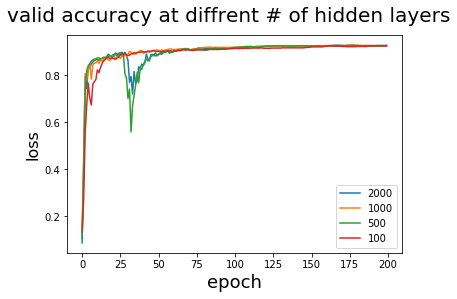

accuracies [2000,1000,500,100] 0.928 0.926 0.925 0.925


In [ ]:
fig = plt.figure()
plt.plot(acc21)
plt.plot(acc22)
plt.plot(acc23)
plt.plot(acc24)
fig.suptitle('valid accuracy at diffrent # of hidden layers', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(['2000','1000','500','100'], loc='lower right')
plt.show()
print("accuracies [2000,1000,500,100]", acc21[-1], acc22[-1], acc23[-1], acc24[-1] )

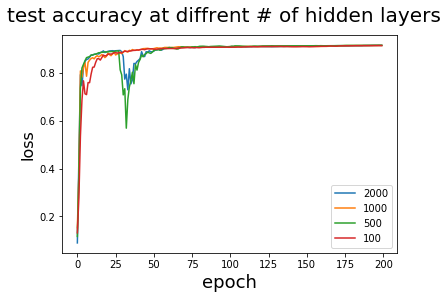

accuracies [2000,1000,500,100] 0.9148311306901615 0.9144640234948604 0.9148311306901615 0.9137298091042585


In [ ]:
fig = plt.figure()
plt.plot(acc31)
plt.plot(acc32)
plt.plot(acc33)
plt.plot(acc34)
fig.suptitle('test accuracy at diffrent # of hidden layers', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(['2000','1000','500','100'], loc='lower right')
plt.show()
print("accuracies [2000,1000,500,100]", acc31[-1], acc32[-1], acc33[-1], acc34[-1] )

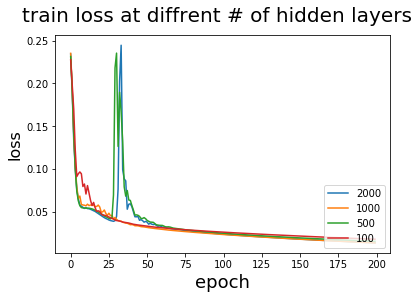

In [ ]:
fig = plt.figure()
plt.plot(L11)
plt.plot(L12)
plt.plot(L13)
plt.plot(L14)
fig.suptitle('train loss at diffrent # of hidden layers', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(['2000','1000','500','100'], loc='lower right')
plt.show()

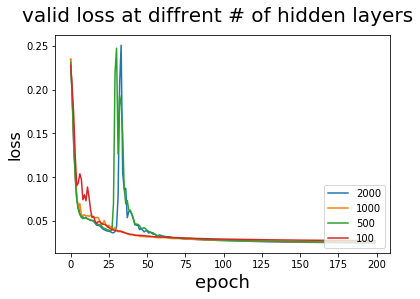

In [ ]:
fig = plt.figure()
plt.plot(L21)
plt.plot(L22)
plt.plot(L23)
plt.plot(L24)
fig.suptitle('valid loss at diffrent # of hidden layers', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(['2000','1000','500','100'], loc='lower right')
plt.show()

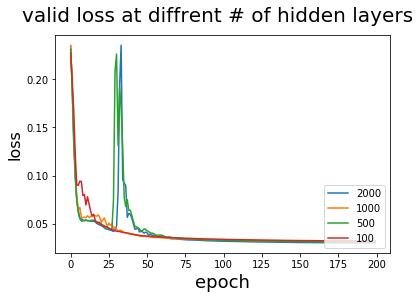

In [ ]:
fig = plt.figure()
plt.plot(L31)
plt.plot(L32)
plt.plot(L33)
plt.plot(L34)
fig.suptitle('valid loss at diffrent # of hidden layers', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend(['2000','1000','500','100'], loc='lower right')
plt.show()

In [ ]:
def convolutionalNeuralNetwork(inputs, labels, lam, drop):
  #reshape input
  input = tf.reshape(inputs, shape=[-1, 28, 28, 1])
  # trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
  # encodedTrain, encodedValid, encodedTest = convertOneHot(trainTarget, validTarget, testTarget)

  
  # recommended to use these tf.nn.conv2d, tf.nn.relu, tf.nn.batch normalization and tf.nn.max pool
  # first layer/ input layer is x

  #3x3 convulotion defined with 32 filters
  W1 = tf.get_variable("W1", [3, 3, 1, 32], dtype='float32',initializer=tf.contrib.layers.xavier_initializer())
  B1 = tf.get_variable('b1', [32], dtype='float32', initializer=tf.contrib.layers.xavier_initializer())

  conv = tf.nn.conv2d(input, W1, strides=[1, 1, 1, 1], padding='SAME')
  convulotionAndBias = tf.nn.bias_add(conv, B1)
  #ReLu Activation layer 1
  conv1 = tf.nn.relu(convulotionAndBias, name='conv1')
  #batch normalization layer 1
  mean, variance = tf.nn.moments(conv1, axes=[0])
  #can vary variance_epsilon=1e-7
  batchNorm = tf.nn.batch_normalization(x=conv1, mean=mean, variance=variance, offset=None, scale=None, variance_epsilon=1e-7)
  #2x2 max pooling layer
  maxpool = tf.nn.max_pool(batchNorm, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  #flatten layer
  flat1 = tf.reshape(maxpool, [-1, 6272])
  #fully connected layer
  W2=tf.get_variable("W2", shape=(14*14*32,64), initializer=tf.contrib.layers.xavier_initializer())
  B2=tf.get_variable("B2", shape=(64), initializer=tf.contrib.layers.xavier_initializer())
  fullyConnected = tf.add(tf.matmul(flat1, W2), B2)
  #ReLu Activation layer 2
  reLu2 = tf.nn.relu(fullyConnected)
  #fully connected layer 2
  W3 = tf.get_variable("W3", shape=(784, [10]), initializer=tf.contrib.layers.xavier_initializer())
  B3 = tf.get_variable('b3', [10], dtype='float32', initializer=tf.contrib.layers.xavier_initializer())
  fullyConnected2 = tf.add(tf.matmul(reLu2, W3), B3)
  #softmax output
  output = tf.nn.softmax(fullyConnected2)
  




In [ ]:
prediction = convolutionalNeuralNetwork()
y = tf.placeholder("float", [None, 10])
x = tf.placeholder("float", [None, 28,28,1])
learning_rate = 1e-4
trainData, validData, testData, trainTarget, validTarget, testTarget = load()
#cross entropy loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
corrected = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
#acc = tf.reduce_mean(corrected) doesn't work needs to be casted
acc = tf.reduce_mean(tf.cast(corrected, tf.float32))

#params 
batchSize = 32
epochs = 50

train_accuracy = []
valid_accuracy = []
test_accuracy = []
train_loss = []
valid_loss = []
test_loss = []
batchSize = 32
epochs = 50
trainData = trainData.reshape(-1, 28, 28, 1)
validData = validData.reshape(-1, 28, 28, 1)
testData = testData.reshape(-1, 28, 28, 1)
numBatches = int(len(trainData)/batchSize)
tf.set_random_seed(300)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for j in range(epochs):
    np.random.seed(300)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data1, target = trainData[randIndx], target[randIndx]
    newtrain, newvalid, newtest = convertOneHot(target, validTarget, testTarget)
    # c = np.c_[trainData.reshape(len(trainData), -1), trainTarget.reshape(len(trainTarget), -1)]

    # np.random.shuffle(c)
    # trainData2 = c[:, :trainData.size//len(trainData)].reshape(trainData.shape)
    # trainTarget2 = c[:, trainData.size//len(trainData):].reshape(trainTarget.shape)

    for i in range(numBatches):
      #now form datasets for target, 
      data = data1[i*batchSize:min((i+1)*batchSize,len(data1))]
      target = newtrain[i*batchSize:min((i+1)*batchSize,len(newtrain))]  
      # data = trainData2[i*batchSize: (i+1)*batchSize]
      # target = trainTarget2[i*batchSize: (i+1)*batchSize]
      # data = np.reshape(data,(batchSize, 784))
      # target = np.reshape(target, (batchSize, 1))
      sess.run(optimizer, feed_dict = {x:data, y:target})
      
    train_loss.append(sess.run(loss, feed_dict = {x:data, y:target}))
    valid_loss.append(sess.run(loss, feed_dict = {x:validData, y:validTarget}))
    test_loss.append(sess.run(loss, feed_dict = {x:testData, y:testTarget}))
    # print("See shapes below")
    # print(data.shape)
    # print(weight.shape)
    # print(target.shape)
    train_accuracy.append(accuracy(data,weight,target))
    valid_accuracy.append(accuracy(validData,weight,validTarget))
    test_accuracy.append(accuracy(testData,weight,testTarget))
    
  
  fig = plt.figure()
  plt.plot(train_loss)
  plt.plot(valid_loss)
  plt.plot(test_loss)
  plt.legend(['train', 'valid', 'test'], loc='upper right')
  # fig.suptitle('loss for  various datasets at LR = 0.005', fontsize=20)
  plt.xlabel('epoch', fontsize=18)
  plt.ylabel('loss', fontsize=16)
  # axes = plt.gca()
  # axes.set_ylim([0,20])
  # # axes.set_xlim([-50,700])
  plt.show()

  fig = plt.figure()
  plt.plot(train_accuracy)
  plt.plot(valid_accuracy)
  plt.plot(test_accuracy)
  plt.legend(['train', 'valid', 'test'], loc='upper right')
  # fig.suptitle('loss for  various datasets at LR = 0.005', fontsize=20)
  plt.xlabel('epoch', fontsize=18)
  plt.ylabel('accuracy', fontsize=16)
  # axes = plt.gca()
  # axes.set_ylim([0,0.7])
  # axes.set_xlim([-50,700])
  plt.show()

  # plt.plot(train_loss)
  # plt.plot(valid_loss)
  # plt.plot(test_loss)
  # plt.show()
print("This is the cost history")
print(train_loss)


In [ ]:
###################

In [ ]:
###################